<a href="https://colab.research.google.com/github/NYU-IEP-2022-3-Classroom/lab5-data-repository-iturok/blob/main/LabAnalysis5_ipynb_Avi_Turok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this assigmnent, you will add to existing code.** Each line you have to write has a numbered comment, so you won't miss one, CODE1, CODE2...CODE25

**If something doesn't work the way you think it should,** please email the Professor and the TAs for help. This notebook started as working code; we removed lines to create the assignment. This process might have introduced an unexpected error. 

As in other assignments, this first code block is meant to set things up. Below, modify the ```!git clone``` line so that the url points to your own data repository.



In [1]:
# necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import scipy.optimize
import itertools,operator

# MODIFY THIS LINE SO THAT THE URL POINTS TO YOUR DATA REPOSITORY by replacing "your_github_username" with your github user name 
# DO NOT delete the "data" at the end of the line 
!git clone https://github.com/NYU-IEP-2022-3-Classroom/Lab5-Sample-Data data



Cloning into 'data'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 402 (delta 0), reused 9 (delta 0), pack-reused 393
Receiving objects: 100% (402/402), 58.29 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Updating files: 100% (510/510), done.


These functions are needed to load the data, check that the data is valid (as in there aren't wild jumps in amplitude or period that would be due to measurement malfunctions), and return the largest sequences of valid data. Not important to know how they work, just how to run them.

In [2]:
def findOrbitFiles (startdir):
  #orbitFiles = findOrbitFiles(startdir)
  # input stardir: path to top level directory (e.g. data_repository/large bob)
  # output orbitFiles: dictionary with paths to orbit files, key names are taken from directories under startdir 
  #   e.g. if startdir has a directory 2mm, then
  #   orbitFiles["2mm"] is a list of paths to all slope files (end _slope.txt) 
  #   under this directory, even in subdirectories

  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python

  orbitFiles = dict()
  for entry in os.scandir(startdir):
    if (entry.is_dir):
      key = entry.name
      orbitFiles[key] = sorted(glob.glob(entry.path + '/**/*_orbit.txt'))
  return orbitFiles

# needed to check data validity
# returns the indices of the first and last element of the largest sequence of true in a list of booleans
def longestTrueSequence(seq):
  #adapted from https://stackoverflow.com/questions/40166522/find-longest-sequence-of-0s-in-the-integer-list
  r = max((list(y) for (x,y) in itertools.groupby((enumerate(seq)),operator.itemgetter(1)) if x), key=len)
  return (r[0][0], r[-1][0])

# Checking data validity (no wild outliers)
# returns indices of the longest sequence of valid data
def sanityCheck(time, slope, amplitude, number, maxTime = np.inf):
  dt = np.diff(time)
  dslope = np.diff(np.abs(np.log(slope)))
  damplitude = np.diff(np.abs(np.log(amplitude)))
  dn = np.diff(number)
  maxperiod = 5 #equivalent to 6 meter pendulum
  maxchange = np.log(1.25) #don't allow an INCREASE of more than 25%
  valid = ((dt > 0) & (dt < maxperiod) & (dslope < maxchange) & (damplitude < maxchange) & (dn > 0) & (dn == 2))
  (start,stop) = longestTrueSequence(valid)
  if start > 0:
    start = start+1
  t0 = time[start]
  tt = time[start:stop+1]
  stop = np.argmax(tt[(tt-t0) <= maxTime]) + start
  return range(start, stop+1)

# load slope and get longest valid sequence
# takes the absolute value of slope 
# inputs: filepath - path of the file
#         maxTime - optional, longest duration to load
# outputs: time - time of the crossing: (file contains every other crossing, e.g. 1 per period)
#          slope - absolute value of slope at the crossing (V/s)
#          majaxis - major axis (mm)
#          minaxis - minor axis (mm)
#          
def loadOrbitFile(filepath, maxTime = 10000000):
  #num crossings	time (s)	maj axis (mm)	min axis (mm)	theta (rad )	slope (V/s)
  num, time, majaxis, minaxis, theta, slope = np.loadtxt(filepath, skiprows = 1, unpack=True)
  validInds = sanityCheck(time,np.abs(slope),majaxis,num,maxTime)
  num = num[validInds]
  time = time[validInds]
  time = time - time[0] #0 reference time
  majaxis = majaxis[validInds]
  minaxis = minaxis[validInds]
  slope = np.abs(slope[validInds])

  return (time,slope,majaxis,minaxis)


These functions do the equation fitting, and you should review how fitting works. FitLine should be especially familiar to you. These will be used to fit your data to exponential and linear curves.

In [3]:
# fitting an exponential
# exponential has two parameters, the y-intercept (a) and the
# exponential multiplier constant (b which for our purposes is -1/tau)
# inputs: x,y - numpy arrays
# outputs: a: fit value of y(0)
#          b: fit value of exonent
#          fity: a * e^(bx) 
def fitExponential(x,y):
  #rescale/recenter data so x starts at 0; y has max value of 1
  xx = x - np.min(x)
  yy = y / np.max(y)
  fitparams, *_ = scipy.optimize.curve_fit(lambda xdata, a, b : a*np.exp(b * xdata), xx, yy, (1, -1/max(xx)))
  a,b = fitparams
  a = a*np.max(y)*np.exp(-b*np.min(x)) #undo effects of rescaling, recentering
  return (a,b, a*np.exp(b*x))

# fitting a line
# line is polynomial of degree 1
# two free parameters, the slope and the y intercept
# inputs: x,y - numpy arrays
# outputs: slope (m): fit value of slope
#          intercept (b): fit value of intercept (y(0))
#          fity: m*x + b
def fitLine(x,y):
  p = np.polyfit(x,y,1)
  slope = p[0]
  intercept = p[1]
  return (slope, intercept, slope*x + intercept)

The below block shows an example of how to load the data for the large bob. This will create two [dictionaries](https://physics.nyu.edu/pine/pymanual/html/chap3/chap3_arrays.html#dictionaries), ```largeSlope``` and ```largeAmplitude```, which contain the displacement as the key and the data from the text file as the value. In order to load the data, you will need to know the file structure of your repository and give the ```findSlopeAndAmplitudeFiles()``` function the proper path to the displacement folders. For example, ```'data/'``` is the top level folder and ```'large bob'``` is the next-level folder that contains all of the displacement folders ```'2'```, ```'3'```, ```'4'```, and so on.

In [4]:
# loading data, need to know file structure of repository
largeBobFiles = findOrbitFiles('data/Large Bob')

#uncomment this line if you are also ready to analyze small bob data
smallBobFiles = findOrbitFiles('data/Small Bob')

print ("you should see a list of the files for 3 mm below:")
largeBobFiles["3"] #note that I need the quotes around 3

you should see a list of the files for 3 mm below:


['data/Large Bob/3/20230201100943/20230201100943_orbit.txt',
 'data/Large Bob/3/20230201101116/20230201101116_orbit.txt',
 'data/Large Bob/3/20230201101303/20230201101303_orbit.txt']

##Write a function to analyze one file

To analyze one file, we need to

1. Load the data from disk
1. Fit the slope vs. time to an exponential relation
1. Fit the amplitude squared (= major axis$^2$ + minor axis$^2$) to an exponential relation
1. Calculate the slope and amplitude lifetimes (the fit gives you a and b in the equation $s = a e^{b t}$, and $\tau = -\frac{1}{b}$). 
1. Plot the **slope** vs. time since the start of the measurement (`time`) and the fit on the same graph. Make the [y-axis logarithmic](https://physics.nyu.edu/pine/pymanual/html/chap5/chap5_plot.html#logarithmic-plots). The fit and probably the data should look like a straight line. Because we may want to analyze an experiment without plotting the data, we should only do the plot if the caller passes in an `matplotlib` `axis` to the optional keyword argument: `slope_plot_axis` to do the plot in. 
1. Plot the **amplitude squared** vs. time since the start of the measurement (`time`) and the fit on the same graph. Make the [y-axis logarithmic](https://physics.nyu.edu/pine/pymanual/html/chap5/chap5_plot.html#logarithmic-plots). The fit and probably the data should look like a straight line. Because we may want to analyze an experiment without plotting the data, we should only do the plot if the caller passes in an `matplotlib` `axis` to the optional keyword argument: `ampsq_plot_axis` to do the plot in. 


We've done a lot of this work for you - you will need to fill in the parts indicated by comments below

analyzing data/Large Bob/3/20230201100943/20230201100943_orbit.txt
I calculated the slope lifetime to be 16.24 and the amplitude squared lifetime to be 16.05


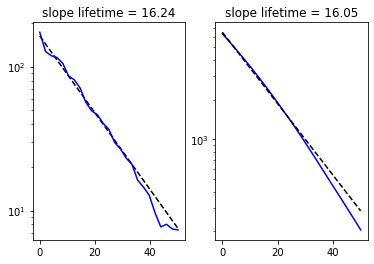

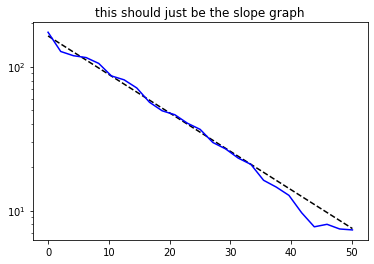

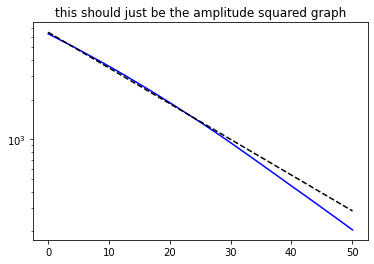

In [5]:
def analyzeFile(file, slope_plot_axis = None, ampsq_plot_axis = None):
  
  time,slope,majaxis,minaxis = loadOrbitFile(file)

  #store the total energy in the variable ampsq
  ampsq = majaxis**2 + minaxis**2

  #fit the amplitude squared to an exponential of time
  a_ampsq, b_ampsq, ampsq_fit = fitExponential(time,ampsq)

  #CODE1: fit an exonential to the slope data
  a_slope,b_slope,slope_fit = fitExponential(time,slope)


  if not(slope_plot_axis is None):
    slope_plot_axis.semilogy(time, slope_fit, 'k--', label = 'slope fit')
    slope_plot_axis.semilogy(time,slope, 'b-', label = 'slope data')
    #CODE2: use semilogy to plot the fit slope vs time, as a dashed black line

  if not(ampsq_plot_axis is None):
    ampsq_plot_axis.semilogy(time,ampsq, 'b-', label = 'ampsq data')
    ampsq_plot_axis.semilogy(time,ampsq_fit, 'k--', label = 'ampsq fit')
    #CODE3: use semilogy to make a plot of time on the linear x-axis vs. amplitude squared on the logarithmic y-axis 
    #CODE4: use semilogy to plot the fit slope vs time, as a dashed black line
 
  
  lifetime_slope = -1/b_slope
  #CODE5: calculate the amplitude squared lifetime and store the result in lifetime_ampsq
  lifetime_ampsq = -1/b_ampsq

  return (lifetime_slope, lifetime_ampsq)

#this code tests your function - make sure it runs correctly

file = largeBobFiles["3"][0] #first 3 mm experiment - change if you don't have this directory structure or this data file
print("analyzing {}".format(file))

plt.figure()
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

(slope_tau, ampsq_tau) = analyzeFile(file, ax1, ax2)
ax1.set_title("slope lifetime = {:.2f}".format(slope_tau))
ax2.set_title("slope lifetime = {:.2f}".format(ampsq_tau))

plt.figure()
ax1 = plt.axes();
analyzeFile(file, slope_plot_axis = ax1)
ax1.set_title("this should just be the slope graph")

plt.figure()
ax1 = plt.axes();
analyzeFile(file, ampsq_plot_axis = ax1)
ax1.set_title("this should just be the amplitude squared graph")

(slope_tau, ampsq_tau) = analyzeFile(file)
print("I calculated the slope lifetime to be {:.2f} and the amplitude squared lifetime to be {:.2f}".format(slope_tau, ampsq_tau))



##Write a function to analyze a whole directory

To analyze the whole directory we need to

1. Create empty lists to store the slope and amplitude lifetime results
2. Loop over all the files in the directory:
  1. Calculate the amplitude squared and slope lifetimes using `analyzeFile`
  1. Append the results to the list of slope lifetimes and amplitude squared lifetimes
3. Return the lists of lifetimes as numpy arrays for the caller to use in later analysis
  

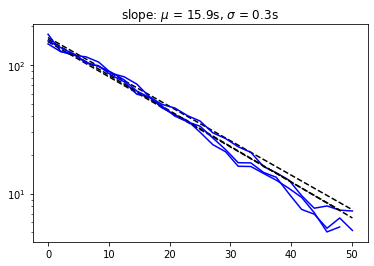

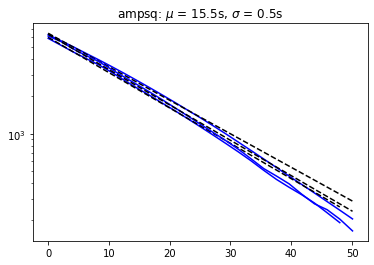

In [6]:
def analyzeDirectory(listOfFiles, slope_plot_axis = None, ampsq_plot_axis = None): 
  #create empty lists slope_lifetime and ampsq_lifetime to store lifetimes
  slope_lifetime = []
  #CODE 6: create an empty list called ampsq_lifetime
  ampsq_lifetime = []
  for file in listOfFiles:
    (slope_tau, ampsq_tau) = analyzeFile(file, slope_plot_axis, ampsq_plot_axis)
    slope_lifetime.append(slope_tau)
    ampsq_lifetime.append(ampsq_tau)
    #CODE 7: append slope_tau to slope_lifetime
    #CODE 8: append ampsq_tau to ampsq_lifetime

  return(np.array(slope_lifetime), np.array(ampsq_lifetime))

#this tests your function 

plt.figure()
ax1 = plt.axes()
plt.figure()
ax2 = plt.axes()

(slope_lifetime, ampsq_lifetime) = analyzeDirectory(largeBobFiles["3"], ax1, ax2)
mu_slope = np.mean(slope_lifetime)
sigma_slope = np.std(slope_lifetime, ddof = 1)#calculates the standard deviation using N-1 in the deonminator
ax1.set_title(r'slope: $\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu_slope, sigma_slope))

mu_ampsq = np.mean(ampsq_lifetime)
sigma_ampsq = np.std(ampsq_lifetime, ddof = 1)#calculates the standard deviation using N-1 in the deonminator
ax2.set_title(r'ampsq: $\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu_ampsq, sigma_ampsq));


##Look at some examples from your data

1. Using `analyzeDirectory`, analyze a short distance (like 1 or 2 mm), an intermediate distance (4 or 5 mm), and a long distance (9 or 10 mm)
1. For each directory analyzed, plot the slope and amplitude data and fits in separate figure windows (see the example above) and title them with the mean and standard deviation of the lifetimes (see the example above)

You can do this with a loop, borrowing liberally/copying from the test code in the cell above. It's always fine to cut and paste my example code, but please just add a comment saying  #copied from example code



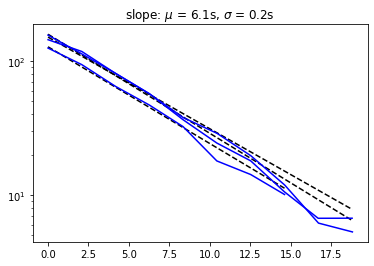

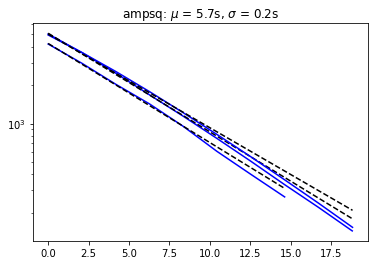

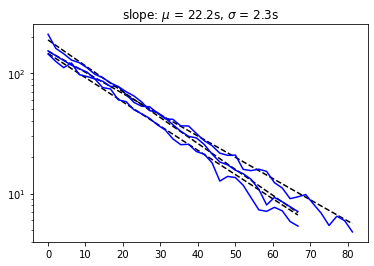

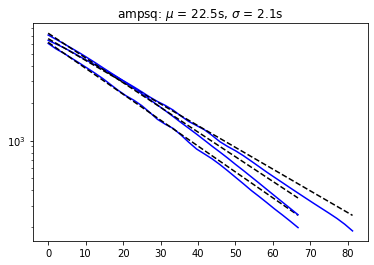

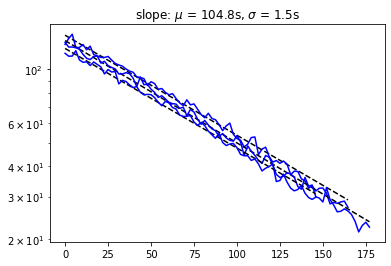

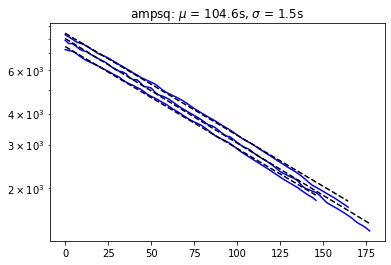

In [7]:
dirsToAnalyze = [largeBobFiles[key] for key in ("1","4","9")]
for expt_set_dir in dirsToAnalyze:
  #CODE 9 (multiple lines of code): create two figures (e.g. plt.figure()), create an axes in each figure and store the `axis handle` (e.g. ax1 = plt.axes())
  #copied
  plt.figure()
  ax1 = plt.axes()
  plt.figure()
  ax2 = plt.axes()
  #CODE 10: call analyzeDirectory on expt_set_dir, ax1, and ax2 : store the output arrays in (slope_lifetime, ampsq_lifetime)
  (slope_lifetime, ampsq_lifetime) = analyzeDirectory(expt_set_dir, ax1, ax2)
  #CODE 11: calculate the mean of the slope lifetime and store it in mu_slope
  mu_slope = np.mean(slope_lifetime)
  #CODE 12: calculate the standard deviation of the slope lifetime, using np.std and the 'ddof = 1' keyword argument 
  #copied
  sigma_slope = np.std(slope_lifetime, ddof = 1)
  #copied
  #CODE 13: title the axis containing the slope fit plot with slope: mu = (mean lifetime), sigma = (std of lifetime)
  ax1.set_title(r'slope: $\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu_slope, sigma_slope))
  #CODE 14-16: The same, but for amplitude squared
  mu_ampsq = np.mean(ampsq_lifetime)
  sigma_ampsq = np.std(ampsq_lifetime, ddof = 1)
  ax2.set_title(r'ampsq: $\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu_ampsq, sigma_ampsq));




##QUESTIONS - answer below 

1. What evidence do you have that the energy decays exponentially (or that it does not)? Can you see any deviations from exponential decay? If so, where are these most evident?
- The slope of the bob on the logarithmic y plot has negative slope, therefore the energy decreses exponentially.
2. Are the slope and amplitude measurements consistent with each other?
- Yes - the slopes and lines of the graphs are very similar.
3. Based on a visual examination of the graphs, which measurement of the energy of the bob has more noise (slope or amplitude squared)
- The slope does.
4. Based on the standard deviation of the lifetime measurements, which measurement of the lifetime (fit to slope or fit to amplitude squared) has less experimental error?
- The amplitude squared has less experimental error.

#Lifetime vs. separation

OK, now let's look at the whole data set. We want to find a relation between the separation and the lifetime. 

We need to do the following:
1. Make a list of all the directories we want analyzed
1. Define a numerical value of the height for each directory. 
1. Loop over all the directories. For each directory
  1. Calculate the lifetime from each experiment. I'm using slope, because I think it was more reliable in my data set. You can use amplitude squared if you think that's better. Justify your choice. 
  1. Find the mean and standard deviation of these lifetimes. 
  1. Calculate the standard error of the mean as the standard deviation over the square root of the number of measurements
1. Make an [error bar plot](https://physics.nyu.edu/pine/pymanual/html/chap5/chap5_plot.html#error-bars) of lifetime vs. separation. My error bars were small enough they were hard to see. How about yours?

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

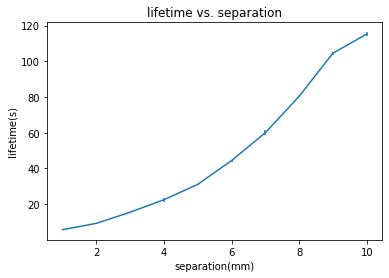

In [8]:
lg_dir = ("1", "2", "3", "4", "5", "6", "7", "8","9","10") #if needed, replace with your directory names
lg_h = np.array((1,2,3,4,5,6,7,8,9,10),'float') #if you changed directory names, make sure you have matching distances here

dirs_to_analyze = [largeBobFiles[k] for k in lg_dir]

#initialize numpy arrays
lg_tau = lg_h*0.;
lg_tau_sigma = lg_h*0.;
lg_tau_sem = lg_h*0.;

for i in range(len(dirs_to_analyze)):
    (_,lifetime) = analyzeDirectory(dirs_to_analyze[i])
    #CODE 17: calculate mean of lifetime list
    lg_tau[i] =  np.mean(lifetime)
    #CODE 18: calculate std of lifetime list, using `ddof = 1` keyword argument
    lg_tau_sigma[i] = np.std(lifetime, ddof = 1)
    lg_tau_sem[i] = lg_tau_sigma[i] / np.sqrt(len(lifetime))

#CODE19: use plt.errorbar to make a plot of lg_tau vs. tg_h with yerr of lg_tau_sem
plt.errorbar(lg_h, lg_tau, yerr = lg_tau_sem)
#CODE20: add title (lifetime vs. separation) xlabel (separation(mm)) and ylabel (lifetime(s)). hint add a ; to the end of the last line to eliminate the annoying text message in the output
plt.title('lifetime vs. separation')
plt.xlabel('separation(mm)')
plt.ylabel ('lifetime(s)')
plt.plot

##Fit lifetime vs. height to a power law

if $\tau = a h^b$, then $\log(\tau) = b \log(h) + \log(a)$ 

in other words, a log-log graph will look like a straight line

use the plt.loglog command to plot lifetime (lg_tau) vs separation (lg_h)

use 'bo-' (blue circles connectd by lines) for the line type




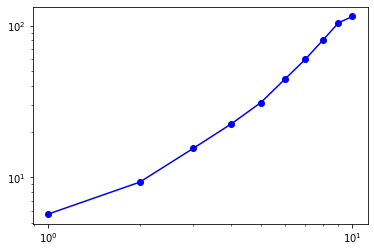

In [9]:
#CODE 21: log log plot of lag_tau (y-axis) vs lg_h (x-axis), with linetype (3rd argument) 'bo-'
plt.loglog(lg_h, lg_tau, 'bo-')

##Fit lifetime vs. height to a power law, take 2

If your data is like mine, this doesn't look like a very straight line. The problem is that the real form is probably something like 

$\tau = a (h + h_0)^b$, and $\log(\tau) = b \log(h+h_0) + \log(a)$ 

where $h_0$ is some offset due to the thickness of the magnet and the aluminum plate. The magnet is 3/16" thick and the plate is 1/8" thick. Together, that's about 8mm of thickness, and the distance between their centers is therefore 4 mm. 

try putting in an offset of 4 mm (plot tau vs. h + 4) and see if it looks more like a straight line. 

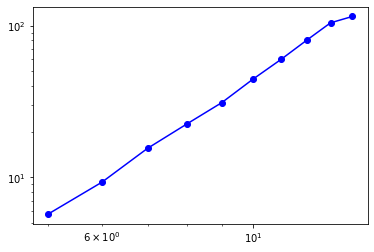

In [10]:
#CODE 22: like 21, but with lg_h+4
plt.loglog(lg_h+4, lg_tau, 'bo-')

##Well that looks good, but....

Now do the same things for offsets of 3 and 5 mm... Do you still see a straight line?

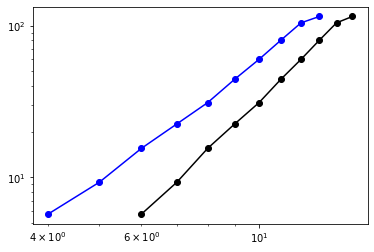

In [11]:
#CODE 23: two lines: log-log plots of lifetime vs. separation + 3mm and + 5mm, one in red and one in blue
plt.loglog(lg_h+3, lg_tau, 'bo-')
plt.loglog(lg_h+5, lg_tau, 'ko-')

## Use the residuals to find the most likely value of the separation

The residuals (the difference of the measured value from the fit value) can be used to tell you the quality of a fit. Assuming each measurement has equal error, the best fit is the one that minimizes the sum of the square of the residuals

minimize $\sum_h(\tau(h) - \tau_{fit}(h))^2$

below, I've written a function that calculates the sum of the squared residuals for a power law fit, given some offset $h_0$.  Then I make a graph of this sum vs. my guess of $h_0$ 

I need you to write a few lines for me


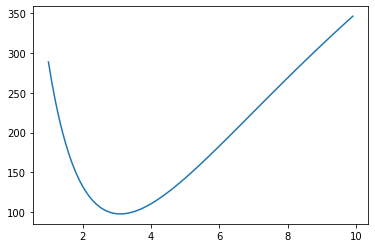

In [12]:
def powerLawResidualSqSum(h, tau, h0):
  x = np.log(h + h0)
  y = np.log(tau)
  m,b,yfit = fitLine(x,y)
  tau_fit = np.exp(yfit)
  #CODE 24: sum of tau - tau_fit squared
  return   np.sum((tau - tau_fit)**2)
 

offset = np.arange(1,10,.1)
residsq = offset*0
for i in range(len(offset)):
  #CODE 25: use powerLawResidualSqSum to calculate the residual for lg_h, lg_tau and offset[i]
  residsq[i] =  powerLawResidualSqSum(lg_h, lg_tau, offset[i])
  
plt.plot(offset, residsq);

By eye, you might be able to find the best guess for h0, but we can actually ask python to find the true minimum, using scipy.optimize. We'll worry about how this works later, but for now just run the code block below to find the minimum 

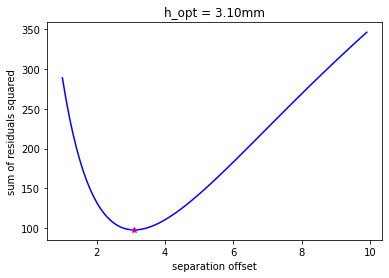

In [13]:
res = scipy.optimize.minimize(lambda h : powerLawResidualSqSum(lg_h, lg_tau,h), 5)
h_opt = res.x[0]
rsq = res.fun
plt.plot(offset, residsq, 'b-', h_opt, rsq, 'm*')
plt.xlabel ('separation offset')
plt.ylabel ('sum of residuals squared')
plt.title('h_opt = {:.2f}mm'.format(h_opt));

Finally, using the best value of the separation (h0) you calculated above, find the power law exponent and plot the data and the fit for lifetime vs. separation together. 

Then, in another figure, plot the residuals with the error bars of the measurements.. x:lg_h, y: lg_tau - $\tau_{fit}$, error bars: lg_tau_sem



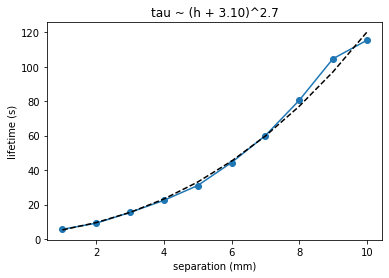

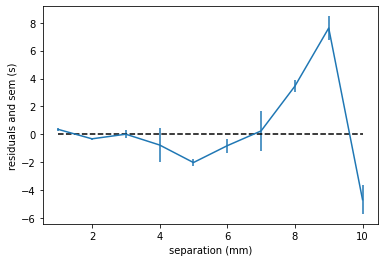

In [14]:
x = np.log(np.array(lg_h) + h_opt)
y = np.log(lg_tau)

#CODE 26: fit to a line y = mx + b
m,b,yfit = fitLine(x,y)
lg_taufit = np.exp(yfit)

#CODE 27: plot lg_tau vs. lg_h with blue circles and lg_taufit vs lg_h with a black dashed line 
plt.plot(lg_h, lg_tau, 'o-')
plt.plot(lg_h, lg_taufit, 'k--')
plt.xlabel('separation (mm)')
plt.ylabel('lifetime (s)')
plt.title('tau ~ (h + {:.2f})^{:.1f}'.format(h_opt, m) );

plt.figure()
#CODE 28: error bar plot of lg_tau-lg_taufit vs. lg_h, yerr = lg_tau_sem
plt.errorbar(lg_h, (lg_tau - lg_taufit), yerr = lg_tau_sem)
plt.xlabel('separation (mm)')
plt.ylabel('residuals and sem (s)')

#Add a black dashed line across the x-axis by plotting lg_h*0 vs lg_h. 
plt.plot(lg_h, lg_h*0, 'k--');

#Small bob time!

Please reuse the analysis steps you did above to calculate lifetime vs separation for the small bob. You do not need to do the power law fit (but you can if you want)

Then make two additional plots
1. Plot lifetime vs. separation for the large and small bobs on the same graph. Use blue circles for the large bob and red circles for the small bob. Add a legend to the plot.
2. Make the same plot, but this time, multiply the small bob lifetime by (4/3)^3. Does this analysis support the relation $\tau \propto m_{bob}$?



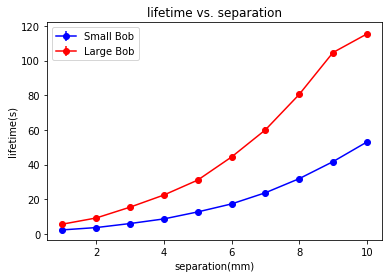

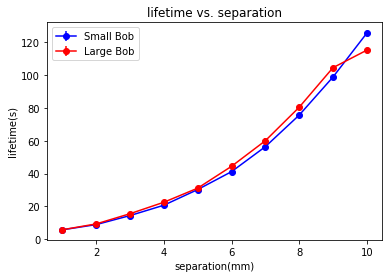

In [15]:
sm_dir = ("1", "2", "3", "4", "5", "6", "7", "8","9","10") #if needed, replace with your directory names
sm_h = np.array((1,2,3,4,5,6,7,8,9,10),'float') #if you changed directory names, make sure you have matching distances here

sm_dirs_to_analyze = [smallBobFiles[k] for k in lg_dir]

#initialize numpy arrays
sm_tau = sm_h*0.;
sm_tau_sigma = sm_h*0.;
sm_tau_sem = sm_h*0.;

for i in range(len(sm_dirs_to_analyze)):
    #CODE 29: (4 lines) calculate the lifetimes for the experiments in the directory, their means, their standard deviations, and their standard errors - make sure you use "sm_dirs_to_analyze" and not "dirs_to_analyze"
    (_,lifetime) = analyzeDirectory(sm_dirs_to_analyze[i])
    sm_tau[i] = np.mean(lifetime) 
    sm_tau_sigma[i] = np.std(lifetime, ddof = 1)
    sm_tau_sem[i] = sm_tau_sigma[i] / np.sqrt(len(lifetime))
#CODE 30 (multiple lines): plot lifetime vs. separation for large and small bobs on same axes - blue circles for large bob, red circles for small bob; add a legend
plt.errorbar(sm_h, sm_tau, yerr=sm_tau_sem, marker='o', linestyle='-', color='blue', label='Small Bob')
plt.errorbar(lg_h ,lg_tau, yerr=lg_tau_sem, marker='o', linestyle='-', color='red', label= 'Large Bob')
plt.title('lifetime vs. separation')
plt.xlabel('separation(mm)')
plt.ylabel('lifetime(s)')
plt.legend()
plt.show()
#CODE 31 (mulitple lines): same as code 30, but plot (4.0/3.0)**3 times the small bob lifetime
plt.errorbar(sm_h, (sm_tau*((4.0/3.0)**3)), yerr=sm_tau_sem, marker='o', linestyle='-', color='blue', label='Small Bob')
plt.errorbar(lg_h ,lg_tau, yerr=lg_tau_sem, marker='o', linestyle='-', color='red', label= 'Large Bob')
plt.title('lifetime vs. separation')
plt.xlabel('separation(mm)')
plt.ylabel('lifetime(s)')
plt.legend()
plt.show()